In [214]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

In [215]:
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/3.1.1/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

# Alpha

In [216]:
# Configure release angle
global alpha
alpha = 35.98
alpha = (alpha * np.pi / 180) + np.pi

In [217]:
def integrate(f, xt, dt, _t):
  k1 = dt*f(xt, _t)
  k2 = dt*f(xt+k1/2., _t+dt/2.)
  k3 = dt*f(xt+k2/2., _t+dt/2.)
  k4 = dt*f(xt+k3, _t+dt)
  new_xt = xt + (1/6.)*(k1 + 2.0*k2 + 2.0*k3 + k4)
  return new_xt

# Release angle
def simulate0(f, x0, tspan, dt, integrate):
  N = int((max(tspan)-min(tspan))/dt)
  x = np.copy(x0)
  tvec = np.linspace(min(tspan),max(tspan),N)
  xtraj = np.zeros((len(x0),N))
  i = 0
  for i in range(N):
    xtraj[:,i] = integrate(f,[*x],dt, tvec[i])

    if (xtraj[:,i][2] > alpha):
      break
    x = np.copy(xtraj[:,i])
    
  return xtraj, i

def transformation(angle, x, y):
  return sym.Matrix([
      [sym.cos(angle), -sym.sin(angle), 0.0, x],
      [sym.sin(angle), sym.cos(angle), 0.0, y],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]
  ])

def unhat(m):
  return sym.Matrix([m[0,3], m[1,3], m[2,3], m[2,1], m[0,2], m[1,0]])

def inverse(m):
  R = sym.Matrix([
      [m[0,0], m[0,1], m[0,2]],
      [m[1,0], m[1,1], m[1,2]],
      [m[2,0], m[2,1], m[2,2]]
  ]).T

  v = -R * sym.Matrix([m[0,3], m[1,3], m[2,3]])
  return sym.Matrix([
      [R[0,0], R[0,1], R[0,2], v[0]],
      [R[1,0], R[1,1], R[1,2], v[1]],
      [R[2,0], R[2,1], R[2,2], v[2]],
      [0,0,0,1]
  ])

In [218]:
# Simulation Configuration
dt = 0.01
t_range = [0,10]

In [219]:
# Length of human arm and torso
L = [0.762, 1.3208]

# Width of human arm and torso
W = [0.1016, 0.1778]

# Mass of human arm and torso
m = [5.4, 60]

# Rotational Inertia of human arm and torso
J = 1

# Gymnastics high bar is 2.8m high
h = 2.8

# Constant acceleration due to gravity
g = 9.8

In [220]:
t = sym.symbols("t")
theta1 = sym.Function("theta_1")(t)
theta2 = sym.Function("theta_2")(t)
x = sym.Function("x")(t)
y = sym.Function("y")(t)

q = sym.Matrix([x, y, theta1, theta2])
qdot = q.diff(t)
qddot = qdot.diff(t)

In [221]:
# Define transformations
g_wa = transformation(0, q[0], q[1])
g_wb = g_wa * transformation(theta1, 0, 0) * transformation(0, 0, L[0]/2)
g_wc = g_wb * transformation(0, 0, L[0]/2)
g_wd = g_wc * transformation(theta2, 0, 0) * transformation(0, 0, L[1]/2)

# Constraint transformations
g_we = g_wd * transformation(0, -W[1]/2, L[1]/2)
g_wf = g_wd * transformation(0, W[1]/2, L[1]/2)

# Corners
g_wg = g_wd * transformation(0, -W[1]/2, -L[1]/2)
g_wh = g_wd * transformation(0, W[1]/2, -L[1]/2)

g_wi = g_wb * transformation(0, -W[0]/2, L[0]/2)
g_wj = g_wb * transformation(0, W[0]/2, L[0]/2)
g_wk = g_wb * transformation(0, -W[0]/2, -L[0]/2)
g_wl = g_wb * transformation(0, W[0]/2, -L[0]/2)

In [222]:
# Inertia matrix
I_0 = sym.Matrix([
    [m[0], 0, 0, 0, 0, 0],
    [0, m[0], 0, 0, 0, 0],
    [0, 0, m[0], 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, J]
]) 

I_1 = sym.Matrix([
    [m[1], 0, 0, 0, 0, 0],
    [0, m[1], 0, 0, 0, 0],
    [0, 0, m[1], 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, J]
]) 

In [223]:
# Body velocities
V_0 = unhat(inverse(g_wb)*g_wb.diff(t))
V_1 = unhat(inverse(g_wd)*g_wd.diff(t))

In [224]:
# Kinetic energy
KE_0 = 0.5 * (V_0.T * I_0 * V_0)[0]
KE_1 = 0.5 * (V_1.T * I_1 * V_1)[0]

In [225]:
# Potential energy
PE_0 = m[0] * g * (g_wb * sym.Matrix([0,0,0,1]))[1]
PE_1 = m[1] * g * (g_wd * sym.Matrix([0,0,0,1]))[1]

In [226]:
# Lagrangian
Lagrangian = sym.simplify((KE_0 + KE_1) - (PE_0 + PE_1))

In [227]:
# Constraints
phi0 = (g_wa * sym.Matrix([0,0,0,1]))[0] 
phi1 = (g_wa * sym.Matrix([0,0,0,1]))[1] - h
phi = sym.Matrix([phi0, phi1])
lamb0, lamb1 = sym.symbols("lambda_0, lambda_1")
lamb = sym.Matrix([lamb0, lamb1])

In [228]:
# External forces
# k1 = 20.0
# t1_path = sym.pi/15. + sym.pi/3. * sym.sin(t/2.)**2
# t2_path = -sym.pi/15. - sym.pi/3. * sym.sin(t/2.)**2
# F = sym.Matrix([0,0, -k1 * (theta1 - t1_path), -k1 * (theta2 - t2_path)])
F = sym.Matrix([4,4, 0, 0])

In [229]:
# Euler-Lagrange Eq
#ELEQ = sym.Eq(Lagrangian.diff(qdot).diff(t) - Lagrangian.diff(q), phi1.diff(q) * lamb1 + phi2.diff(q) * lamb2 + F)
ELEQ0 = sym.Eq(Lagrangian.diff(qdot).diff(t) - Lagrangian.diff(q), phi0.diff(q) * lamb0 + phi1.diff(q) * lamb1)
phi0_EQ = sym.Eq(0, phi0.diff(t).diff(t))
phi1_EQ = sym.Eq(0, phi1.diff(t).diff(t))

In [230]:
sol0 = sym.solve([ELEQ0,phi0_EQ, phi1_EQ], [*qddot, *lamb])

In [231]:
# Lambdify
sol_x = sym.lambdify([*q, *qdot], sol0[qddot[0]])
sol_y = sym.lambdify([*q, *qdot], sol0[qddot[1]])
sol_theta1 = sym.lambdify([*q, *qdot], sol0[qddot[2]])
sol_theta2 = sym.lambdify([*q, *qdot], sol0[qddot[3]])

In [232]:
def dyn0(s, t):
  return np.array([s[4], s[5], s[6], s[7], 
                   sol_x(*s), sol_y(*s), sol_theta1(*s), sol_theta2(*s)])

In [233]:
# x, y, theta1, theta2
s0 = [0.0, h, 0.0, 0.0, 0.0, 0.0, 1, 2]
traj0, i = simulate0(dyn0, s0, t_range, dt, integrate)
print(i)
traj0 = np.delete(traj0, np.s_[i:traj0.shape[1]], axis=1)
print(traj0.shape)

94
(8, 94)


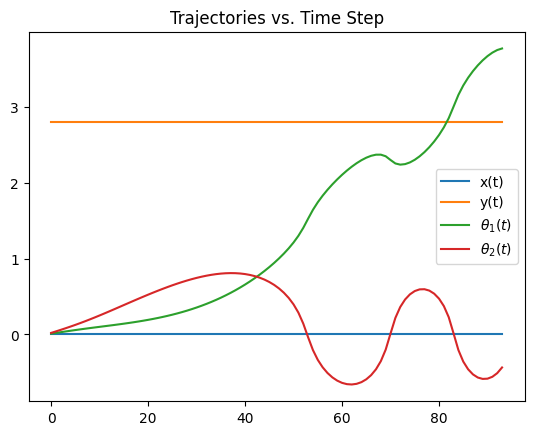

In [234]:
plt.figure()
plt.plot(traj0[0:4].T)
plt.legend(["x(t)", "y(t)", r'$\theta_1(t)$', r'$\theta_2(t)$'])
plt.title("Trajectories vs. Time Step")
plt.show()

In [235]:
def animate(input_arr, L, W, T=10):


    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data

    x_array = input_arr[0]
    y_array = input_arr[1]
    theta1_array = input_arr[2]
    theta2_array = input_arr[3]

    N = len(input_arr[0]) # Need this for specifying length of simulation


    ###############################################
    # Define arrays containing data for frame axes

    # Use homogeneous tranformation to transfer these two axes/points
    # back to the fixed frame
    b_1_x = np.zeros(N)
    b_1_y = np.zeros(N)
    b_2_x = np.zeros(N)
    b_2_y = np.zeros(N)
    b_3_x = np.zeros(N)
    b_3_y = np.zeros(N)
    b_4_x = np.zeros(N)
    b_4_y = np.zeros(N)

    c_1_x = np.zeros(N)
    c_1_y = np.zeros(N)
    c_2_x = np.zeros(N)
    c_2_y = np.zeros(N)
    c_3_x = np.zeros(N)
    c_3_y = np.zeros(N)
    c_4_x = np.zeros(N)
    c_4_y = np.zeros(N)

    def transform_np(angle, x, y):
      return np.array([[np.cos(angle), -np.sin(angle), 0.0, x],[np.sin(angle), np.cos(angle), 0.0, y],[0.0, 0.0, 1.0, 0.0],[0.0, 0.0, 0.0, 1.0]])

    for t in range(N): # iteration through each time step
        # evaluate homogeneous transformation


        _x = x_array[t]
        _y = y_array[t]
        _t1 = theta1_array[t]
        _t2 = theta2_array[t]

        t_wa = transform_np(0, _x, _y)
        t_wb = t_wa @ transform_np(_t1,0,0) @ transform_np(0,0, L[0]/2)
        t_wd = t_wb @ transform_np(0,0, L[0]/2) @ transform_np(_t2,0,0) @ transform_np(0,0,L[1]/2)

        b = t_wb.dot(np.array([W[0]/2, L[0]/2, 0, 1]))
        b_1_x[t] = ((g_wj * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        b_1_y[t] = ((g_wj * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        b = t_wb.dot(np.array([-W[0]/2, L[0]/2, 0, 1]))
        b_2_x[t] = ((g_wi * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        b_2_y[t] = ((g_wi * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        b = t_wb.dot(np.array([-W[0]/2, -L[0]/2, 0, 1]))
        b_3_x[t] = ((g_wk * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        b_3_y[t] = ((g_wk * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        b = t_wb.dot(np.array([W[0]/2, -L[0]/2, 0, 1]))
        b_4_x[t] = ((g_wl * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        b_4_y[t] = ((g_wl * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))

        c = t_wd.dot(np.array([W[1]/2, L[1]/2, 0, 1]))
        c_1_x[t] = ((g_wf * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        c_1_y[t] = ((g_wf * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        c = t_wd.dot(np.array([-W[1]/2, L[1]/2, 0, 1]))
        c_2_x[t] = ((g_we * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        c_2_y[t] = ((g_we * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        c = t_wd.dot(np.array([-W[1]/2, -L[1]/2, 0, 1]))
        c_3_x[t] = ((g_wg * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        c_3_y[t] = ((g_wg * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))


        c = t_wd.dot(np.array([W[1]/2, -L[1]/2, 0, 1]))
        c_4_x[t] = ((g_wh * sym.Matrix([0,0,0,1]))[0]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))
        c_4_y[t] = ((g_wh * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*input_arr.T[t]])))

    ####################################
    # Using these to specify axis limits.
    xm = -2 #np.min(xx1)-0.5
    xM = 10 #np.max(xx1)+0.5
    ym = 0 #np.min(yy1)-2.5
    yM = 10 #np.max(yy1)+1.5

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[

        dict(name='B'),
        dict(name='C'),
        dict(x=[xm, xM], y=[0,0], mode="lines", name="Ground", line=dict(color="green",width=4)),
    ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Gymnastics High Bar Dismount Simulator', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )

    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[
        dict(data=[
            dict(x=[b_1_x[k],
                    b_2_x[k],
                    b_3_x[k],
                    b_4_x[k],
                    b_1_x[k]],
                 y=[b_1_y[k],
                    b_2_y[k],
                    b_3_y[k],
                    b_4_y[k],
                    b_1_y[k]],
                 mode="lines",
                 line=dict(color="red",width=4,),),                 
                 
            dict(x=[c_1_x[k],
                    c_2_x[k],
                    c_3_x[k],
                    c_4_x[k],
                    c_1_x[k]],
                 y=[c_1_y[k],
                    c_2_y[k],
                    c_3_y[k],
                    c_4_y[k],
                    c_1_y[k]],
                 mode="lines",
                 line=dict(color="blue",width=4,),)
        
          ]) for k in range(N)
      ]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

In [236]:
animate(traj0, L, W)

Output hidden; open in https://colab.research.google.com to view.

In [237]:
ELEQ1 = sym.Eq(Lagrangian.diff(qdot).diff(t), Lagrangian.diff(q))
ddtemp = list(sym.symbols('a,b,c,d'))

In [238]:
phi_impact0 = (g_we * sym.Matrix([0,0,0,1]))[1]-0.0
phi_impact1 = (g_wf * sym.Matrix([0,0,0,1]))[1]-0.0
dphi_impact0 = phi_impact0.diff(q)
dphi_impact1 = phi_impact1.diff(q)
dLdqdot = sym.Matrix([Lagrangian]).jacobian(qdot)
#H = dLdqdot*qdot - sym.Matrix([Lagrangian])

In [239]:
print(phi_impact0.subs(dict(zip([*q, *qdot], [*traj0.T[-1]]))))
print(phi_impact1.subs(dict(zip([*q, *qdot], [*traj0.T[-1]]))))
display(traj0.T[-1])
display(((g_we * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*traj0.T[-1]]))))
display(((g_wf * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot], [*traj0.T[-1]]))))

0.902563554398323
0.868848887998373


array([ 0.        ,  2.8       ,  3.76770708, -0.435338  ,  0.        ,
        0.        ,  1.26029224,  9.09513222])

0.902563554398323

0.868848887998373

In [240]:
#display(H)
display(dphi_impact0)

⎡                                                                     0       
⎢                                                                             
⎢                                                                    1.0      
⎢                                                                             
⎢0.0889⋅sin(θ₁(t))⋅sin(θ₂(t)) - 1.3208⋅sin(θ₁(t))⋅cos(θ₂(t)) - 0.762⋅sin(θ₁(t)
⎢                                                                             
⎣         0.0889⋅sin(θ₁(t))⋅sin(θ₂(t)) - 1.3208⋅sin(θ₁(t))⋅cos(θ₂(t)) - 1.3208

                                                               ⎤
                                                               ⎥
                                                               ⎥
                                                               ⎥
) - 1.3208⋅sin(θ₂(t))⋅cos(θ₁(t)) - 0.0889⋅cos(θ₁(t))⋅cos(θ₂(t))⎥
                                                               ⎥
⋅sin(θ₂(t))⋅cos(θ₁(t)) - 0.0889⋅cos(θ₁(t))⋅cos(θ₂(t))   

In [241]:
temp = list(sym.symbols(r'x, y, \theta_1, \theta_2, \dot{x}, \dot{y}, \dot{\theta_1}, \dot{\theta_2}, \ddot{x}, \ddot{y}, \ddot{\theta_1}, \ddot{\theta_2}'))
dummy_sub = dict(zip([*q, *qdot, *qddot], [*temp]))

dLdqdot_dummy = sym.simplify(dLdqdot.subs(dummy_sub))
#H_dummy = sym.simplify(H.subs(dummy_sub))
dphi_impact0_dummy = sym.simplify(dphi_impact0.subs(dummy_sub))
dphi_impact1_dummy = sym.simplify(dphi_impact1.subs(dummy_sub))
phi_impact0_dummy = sym.simplify(phi_impact0.subs(dummy_sub))
phi_impact1_dummy = sym.simplify(phi_impact1.subs(dummy_sub))

In [242]:
# display(H_dummy)
# display(temp)
# display(dummy_sub)

In [243]:
# display(dLdqdot_dummy)
# display(H_dummy)
# display(dphi_impact0_dummy)
# display(dphi_impact1_dummy)

In [244]:
temp_plus = list(sym.symbols(r"\dot{x}^{+}, \dot{y}^{+}, \dot{\theta_1}^{+}, \dot{\theta_2}^{+}"))
lamb0, lamb1 = sym.symbols(r"\lambda_0, \lambda_1")
dLdqdot_dummy_plus = dLdqdot_dummy.subs(dict(zip([*temp[4:8]], [*temp_plus])))
#H_dummy_plus = H_dummy.subs(dict(zip([*temp[4:8]], [*temp_plus])))
impact_eq0 = sym.Eq(dLdqdot_dummy_plus - dLdqdot_dummy, dphi_impact0_dummy.T * lamb0)
impact_eq1 = sym.Eq(dLdqdot_dummy_plus - dLdqdot_dummy, dphi_impact1_dummy.T * lamb1)
#impact_eq_ham = sym.Eq(H_dummy_plus[0] - H_dummy[0], 0)

impact_plastic_eq0 = sym.Eq(0, (dphi_impact0_dummy.T * qdot.subs(dummy_sub))[0])
impact_plastic_eq1 = sym.Eq(0, (dphi_impact1_dummy.T * qdot.subs(dummy_sub))[0])

impact_eq0 = sym.simplify(impact_eq0)
impact_eq1 = sym.simplify(impact_eq1)
impact_plastic_eq0 = sym.simplify(impact_plastic_eq0.subs(dict(zip([*temp[4:8]], [*temp_plus]))))
impact_plastic_eq1 = sym.simplify(impact_plastic_eq1.subs(dict(zip([*temp[4:8]], [*temp_plus]))))

display(impact_plastic_eq0)
display(impact_plastic_eq1)

#impact_eq_ham = sym.simplify(impact_eq_ham)

\dot{\theta_1}__{+}⋅(0.762⋅sin(\theta₁) + 1.3208⋅sin(\theta₁ + \theta₂) + 0.08
89⋅cos(\theta₁ + \theta₂)) + \dot{\theta_2}__{+}⋅(1.3208⋅sin(\theta₁ + \theta₂
) + 0.0889⋅cos(\theta₁ + \theta₂)) - \dot{y}__{+} = 0

\dot{\theta_1}__{+}⋅(0.762⋅sin(\theta₁) + 1.3208⋅sin(\theta₁ + \theta₂) - 0.08
89⋅cos(\theta₁ + \theta₂)) + \dot{\theta_2}__{+}⋅(1.3208⋅sin(\theta₁ + \theta₂
) - 0.0889⋅cos(\theta₁ + \theta₂)) - \dot{y}__{+} = 0

In [245]:
# impact0_sols = sym.solve([impact_eq0, impact_eq_ham], [*temp_plus, lamb0])
# impact1_sols = sym.solve([impact_eq1, impact_eq_ham], [*temp_plus, lamb1])

display(impact_plastic_eq0)

\dot{\theta_1}__{+}⋅(0.762⋅sin(\theta₁) + 1.3208⋅sin(\theta₁ + \theta₂) + 0.08
89⋅cos(\theta₁ + \theta₂)) + \dot{\theta_2}__{+}⋅(1.3208⋅sin(\theta₁ + \theta₂
) + 0.0889⋅cos(\theta₁ + \theta₂)) - \dot{y}__{+} = 0

In [246]:
def impact_update(s, impact_eq, lamb, plastic):
  impact = impact_eq.subs(dict(zip([*temp[0:8]], [*s])))
  #ham = impact_eq_ham.subs(dict(zip([*temp[0:8]], [*s])))
  # display(plastic)
  impact_plastic = plastic.subs(dict(zip([*temp[0:8]], [*s])))

  # display(impact)
  # display(impact_plastic)
  impact_sols = sym.solve([impact, impact_plastic], [*temp_plus, lamb],dict=True)
  # display(impact_sols)
  # if (len(impact_sols) == 1):
  #   # Invalid
  #   return np.array([]) 

  for sol in impact_sols:
    if not (abs(sol[lamb]) < 1e-5):
      return np.array([s[0], s[1], s[2], s[3], float(sym.N(sol[temp_plus[0]])), float(sym.N(sol[temp_plus[1]])), float(sym.N(sol[temp_plus[2]])), float(sym.N(sol[temp_plus[3]]))]) 

#impact_update([1,1,1,1,1,1,1,1], impact_eq0, lamb0, impact_plastic_eq0)

In [247]:
# impact0_sol = sym.lambdify([*temp], impact0_sols[0][0])
# impact1_sol = sym.lambdify([*temp], impact1_sols[0][0])

In [248]:
phi0_sol = sym.lambdify([*q, *qdot], phi_impact0)
phi1_sol = sym.lambdify([*q, *qdot], phi_impact1)

In [249]:
def impact_condition(s, phi_in):
  if(phi_in(*s) < 0):
    print("impact")
    display(((g_we * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot],[*s]))))
    display(((g_wf * sym.Matrix([0,0,0,1]))[1]).subs(dict(zip([*q, *qdot],[*s]))))

    return True
  return False

In [250]:
# Impact
def simulate1(f, x0, tspan, dt, integrate):
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
      if impact_condition(x, phi0_sol) == True:
        x = impact_update(np.copy(xtraj[:,i-1]), impact_eq0, lamb0, impact_plastic_eq0)
      
      elif impact_condition(x, phi1_sol) == True:
        x = impact_update(np.copy(xtraj[:,i-1]), impact_eq1, lamb1, impact_plastic_eq1)

      xtraj[:,i]=integrate(f,x,dt, tvec[i])
      x = np.copy(xtraj[:,i])
    return xtraj 

In [251]:
def dyn1(s, t):
  print(t)
  # print(s)
  sol1 = sym.solve([ELEQ1.subs(dict(zip([*qddot, *q, *qdot], [*ddtemp, *s])))], [*ddtemp])

  return np.array([s[4], s[5], s[6], s[7], 
                   sol1[ddtemp[0]], sol1[ddtemp[1]], sol1[ddtemp[2]], sol1[ddtemp[3]]])

In [252]:
s1 = traj0.T[-1]
traj1 = simulate1(dyn1, s1, [0,2], 0.01, integrate)

0.0
0.005
0.005
0.01
0.010050251256281407
0.015050251256281406
0.015050251256281406
0.020050251256281407
0.020100502512562814
0.025100502512562815
0.025100502512562815
0.030100502512562813
0.03015075376884422
0.03515075376884422
0.03515075376884422
0.04015075376884422
0.04020100502512563
0.045201005025125626
0.045201005025125626
0.05020100502512563
0.05025125628140704
0.055251256281407035
0.055251256281407035
0.06025125628140704
0.06030150753768844
0.06530150753768844
0.06530150753768844
0.07030150753768843
0.07035175879396985
0.07535175879396985
0.07535175879396985
0.08035175879396984
0.08040201005025126
0.08540201005025126
0.08540201005025126
0.09040201005025125
0.09045226130653267
0.09545226130653267
0.09545226130653267
0.10045226130653266
0.10050251256281408
0.10550251256281408
0.10550251256281408
0.11050251256281407
0.11055276381909548
0.11555276381909549
0.11555276381909549
0.12055276381909548
0.12060301507537688
0.12560301507537688
0.12560301507537688
0.1306030150753769
0.130653

-0.0787314919640252

0.0670181051740282

0.7035175879396985
0.7085175879396985
0.7085175879396985
0.7135175879396985
impact


-0.0779379552225195

0.0752989576146839

0.7135678391959799
0.7185678391959799
0.7185678391959799
0.7235678391959799
impact


-0.0779221665337799

0.0815142501103654

0.7236180904522613
0.7286180904522613
0.7286180904522613
0.7336180904522613
impact


-0.0784919908791462

0.0860534153855348

0.7336683417085427
0.7386683417085427
0.7386683417085427
0.7436683417085427
impact


-0.0794656088075771

0.0892399769736525

0.7437185929648241
0.7487185929648241
0.7487185929648241
0.7537185929648241
impact


-0.0806962346602755

0.0913198073038171

0.7537688442211056
0.7587688442211056
0.7587688442211056
0.7637688442211056
impact


-0.0820760133496723

0.0924684549477685

0.7638190954773869
0.7688190954773869
0.7688190954773869
0.7738190954773869
impact


-0.0835298470884711

0.0928056262119625

0.7738693467336684
0.7788693467336684
0.7788693467336684
0.7838693467336684
impact


-0.0850068494147104

0.0924092360851865

0.7839195979899498
0.7889195979899498
0.7889195979899498
0.7939195979899498
impact


-0.0864728969789440

0.0913262064515983

0.7939698492462312
0.7989698492462312
0.7989698492462312
0.8039698492462312
impact


-0.0879052612488981

0.0895796749793433

0.8040201005025126
0.8090201005025126
0.8090201005025126
0.8140201005025126
impact


-0.0892893088194585

0.0871730974636750

0.8140703517587939
0.819070351758794
0.819070351758794
0.824070351758794
impact


-0.0906170290551221

0.0840917869418282

0.8241206030150754
0.8291206030150754
0.8291206030150754
0.8341206030150754
impact


-0.0918871938473428

0.0803022654141647

0.8341708542713568
0.8391708542713568
0.8391708542713568
0.8441708542713569
impact


-0.0931070202389704

0.0757496533639911

0.8442211055276382
0.8492211055276382
0.8492211055276382
0.8542211055276382
impact


-0.0942951488625588

0.0703532984439431

0.8542713567839196
0.8592713567839196
0.8592713567839196
0.8642713567839196
impact


-0.0954854918813512

0.0640009737628451

0.864321608040201
0.869321608040201
0.869321608040201
0.874321608040201
impact


-0.0967310943297072

0.0565421401183437

0.8743718592964824
0.8793718592964824
0.8793718592964824
0.8843718592964824
impact


-0.0981069049411613

0.0477805903228464

0.8844221105527639
0.8894221105527639
0.8894221105527639
0.8944221105527639
impact


-0.0997108582930761

0.0374656575716493

0.8944723618090452
0.8994723618090452
0.8994723618090452
0.9044723618090452
impact


-0.101664450484032

0.0252785188333400

0.9045226130653267
0.9095226130653267
0.9095226130653267
0.9145226130653267
impact


-0.104116981255834

0.0108057556120875

0.914572864321608
0.919572864321608
0.919572864321608
0.924572864321608
impact


-0.107261539898289

-0.00651439086250805

0.9246231155778895
0.9296231155778895
0.9296231155778895
0.9346231155778895
impact


-0.111377291097427

-0.0275005048903769

0.9346733668341709
0.9396733668341709
0.9396733668341709
0.9446733668341709
impact


-0.116929403483711

-0.0534488189562972

0.9447236180904522
0.9497236180904522
0.9497236180904522
0.9547236180904523
impact


-0.124803853515028

-0.0865853366424105

0.9547738693467337
0.9597738693467337
0.9597738693467337
0.9647738693467337
impact


-0.136792371336272

-0.130768570254857

0.964824120603015
0.969824120603015
0.969824120603015
0.974824120603015
impact


-0.154797022985565

-0.188613753684509

0.9748743718592965
0.9798743718592965
0.9798743718592965
0.9848743718592965
impact


-0.169568728000667

-0.237599846095304

0.9849246231155779
0.9899246231155779
0.9899246231155779
0.9949246231155779
impact


-0.179270334222651

-0.271092250659018

0.9949748743718593
0.9999748743718593
0.9999748743718593
1.0049748743718592
impact


-0.186688861560546

-0.296131606827513

1.0050251256281406
1.0100251256281405
1.0100251256281405
1.0150251256281406
impact


-0.191993898071810

-0.314756287049142

1.015075376884422
1.020075376884422
1.020075376884422
1.025075376884422
impact


-0.195093260112399

-0.328001331298117

1.0251256281407035
1.0301256281407034
1.0301256281407034
1.0351256281407035
impact


-0.196285601558268

-0.337019254947210

1.035175879396985
1.0401758793969849
1.0401758793969849
1.045175879396985
impact


-0.196110916538562

-0.342983655779450

1.0452261306532664
1.0502261306532663
1.0502261306532663
1.0552261306532664
impact


-0.195068689675282

-0.346832042828884

1.0552763819095476
1.0602763819095475
1.0602763819095475
1.0652763819095477
impact


-0.193506647496509

-0.349207569903794

1.065326633165829
1.070326633165829
1.070326633165829
1.075326633165829
impact


-0.191633817065508

-0.350522783181135

1.0753768844221105
1.0803768844221104
1.0803768844221104
1.0853768844221106
impact


-0.189566857312681

-0.351040662255278

1.085427135678392
1.090427135678392
1.090427135678392
1.095427135678392
impact


-0.187370783638731

-0.350936330506634

1.0954773869346734
1.1004773869346733
1.1004773869346733
1.1054773869346735
impact


-0.185087914013771

-0.350338478341799

1.105527638190955
1.1105276381909548
1.1105276381909548
1.115527638190955
impact


-0.182758599090512

-0.349357880246175

1.1155778894472361
1.120577889447236
1.120577889447236
1.1255778894472361
impact


-0.180437814795217

-0.348109297092770

1.1256281407035176
1.1306281407035175
1.1306281407035175
1.1356281407035176
impact


-0.178209505712850

-0.346729779214700

1.135678391959799
1.140678391959799
1.140678391959799
1.145678391959799
impact


-0.176197121647822

-0.345392179124730

1.1457286432160805
1.1507286432160804
1.1507286432160804
1.1557286432160805
impact


-0.174564454992606

-0.344307706759576

1.155778894472362
1.1607788944723618
1.1607788944723618
1.165778894472362
impact


-0.173498107153889

-0.343708164201739

1.1658291457286432
1.170829145728643
1.170829145728643
1.1758291457286432
impact


-0.173167655657483

-0.343803560532875

1.1758793969849246
1.1808793969849245
1.1808793969849245
1.1858793969849246
impact


-0.173675504539139

-0.344728116288381

1.185929648241206
1.190929648241206
1.190929648241206
1.195929648241206
impact


-0.175024081353538

-0.346504777338170

1.1959798994974875
1.2009798994974874
1.2009798994974874
1.2059798994974875
impact


-0.177121760029682

-0.349051534460070

1.206030150753769
1.2110301507537689
1.2110301507537689
1.216030150753769
impact


-0.179821315386136

-0.352222852795996

1.2160804020100502
1.22108040201005
1.22108040201005
1.2260804020100502
impact


-0.182965161594771

-0.355858344461076

1.2261306532663316
1.2311306532663315
1.2311306532663315
1.2361306532663316
impact


-0.186416503137092

-0.359816236185942

1.236180904522613
1.241180904522613
1.241180904522613
1.246180904522613
impact


-0.190071404156197

-0.363986416004054

1.2462311557788945
1.2512311557788944
1.2512311557788944
1.2562311557788945
impact


-0.193856975749491

-0.368288776226832

1.256281407035176
1.2612814070351759
1.2612814070351759
1.266281407035176
impact


-0.197722422356053

-0.372664136289847

1.2663316582914572
1.2713316582914571
1.2713316582914571
1.2763316582914572
impact


-0.201627158061981

-0.377062280049377

1.2763819095477387
1.2813819095477386
1.2813819095477386
1.2863819095477387
impact


-0.205527495369620

-0.381428773362047

1.2864321608040201
1.29143216080402
1.29143216080402
1.2964321608040201
impact


-0.209362069896215

-0.385690842969207

1.2964824120603016
1.3014824120603015
1.3014824120603015
1.3064824120603016
impact


-0.213036783827955

-0.389743233564233

1.306532663316583
1.311532663316583
1.311532663316583
1.316532663316583
impact


-0.216413256988774

-0.393438146809671

1.3165829145728642
1.3215829145728641
1.3215829145728641
1.3265829145728643
impact


-0.219310272889384

-0.396588665613133

1.3266331658291457
1.3316331658291456
1.3316331658291456
1.3366331658291457
impact


-0.221530639552260

-0.398997510690828

1.3366834170854272
1.341683417085427
1.341683417085427
1.3466834170854272
impact


-0.222915370642656

-0.400511924200969

1.3467336683417086
1.3517336683417085
1.3517336683417085
1.3567336683417086
impact


-0.223400838511942

-0.401079416547564

1.35678391959799
1.36178391959799
1.36178391959799
1.36678391959799
impact


-0.223039961146512

-0.400765834617296

1.3668341708542713
1.3718341708542712
1.3718341708542712
1.3768341708542713
impact


-0.221973690431734

-0.399723602835290

1.3768844221105527
1.3818844221105526
1.3818844221105526
1.3868844221105527
impact


-0.220377818419531

-0.398136409256168

1.3869346733668342
1.391934673366834
1.391934673366834
1.3969346733668342
impact


-0.218418083854777

-0.396173397143939

1.3969849246231156
1.4019849246231155
1.4019849246231155
1.4069849246231156
impact


-0.216227510759623

-0.393966239305397

1.407035175879397
1.412035175879397
1.412035175879397
1.417035175879397
impact


-0.213902369401050

-0.391605021818893

1.4170854271356783
1.4220854271356782
1.4220854271356782
1.4270854271356783
impact


-0.211507907182339

-0.389143904324939

1.4271356783919598
1.4321356783919597
1.4321356783919597
1.4371356783919598
impact


-0.209087052821905

-0.386609751485417

1.4371859296482412
1.442185929648241
1.442185929648241
1.4471859296482412
impact


-0.206668655799464

-0.384010341336403

1.4472361809045227
1.4522361809045226
1.4522361809045226
1.4572361809045227
impact


-0.204274116839926

-0.381341050984765

1.4572864321608041
1.462286432160804
1.462286432160804
1.4672864321608041
impact


-0.201922360980462

-0.378590006829244

1.4673366834170853
1.4723366834170852
1.4723366834170852
1.4773366834170854
impact


-0.199633462820174

-0.375742037713920

1.4773869346733668
1.4823869346733667
1.4823869346733667
1.4873869346733668
impact


-0.197431244971896

-0.372781775075266

1.4874371859296482
1.4924371859296481
1.4924371859296481
1.4974371859296483
impact


-0.195345051800617

-0.369696115669820

1.4974874371859297
1.5024874371859296
1.5024874371859296
1.5074874371859297
impact


-0.193410748714794

-0.366476092239740

1.5075376884422111
1.512537688442211
1.512537688442211
1.5175376884422112
impact


-0.191670856364176

-0.363118025123934

1.5175879396984926
1.5225879396984925
1.5225879396984925
1.5275879396984926
impact


-0.190173632092284

-0.359623684804205

1.5276381909547738
1.5326381909547737
1.5326381909547737
1.5376381909547738
impact


-0.188970901284583

-0.355999129275699

1.5376884422110553
1.5426884422110552
1.5426884422110552
1.5476884422110553
impact


-0.188114571186100

-0.352251957110278

1.5477386934673367
1.5527386934673366
1.5527386934673366
1.5577386934673367
impact


-0.187652060711309

-0.348386993124506

1.5577889447236182
1.562788944723618
1.562788944723618
1.5677889447236182
impact


-0.187621307742018

-0.344400882748001

1.5678391959798996
1.5728391959798995
1.5728391959798995
1.5778391959798996
impact


-0.188046408760625

-0.340276564563297

1.5778894472361809
1.5828894472361807
1.5828894472361807
1.5878894472361809
impact


-0.188935062017262

-0.335978851651623

1.5879396984924623
1.5929396984924622
1.5929396984924622
1.5979396984924623
impact


-0.190278650190033

-0.331452145130638

1.5979899497487438
1.6029899497487436
1.6029899497487436
1.6079899497487438
impact


-0.192055075215907

-0.326620629040815

1.6080402010050252
1.613040201005025
1.613040201005025
1.6180402010050252
impact


-0.194233662184841

-0.321390467207575

1.6180904522613067
1.6230904522613065
1.6230904522613065
1.6280904522613067
impact


-0.196780935677291

-0.315652996794975

1.6281407035175879
1.6331407035175878
1.6331407035175878
1.638140703517588
impact


-0.199665950877044

-0.309288044951601

1.6381909547738693
1.6431909547738692
1.6431909547738692
1.6481909547738693
impact


-0.202863836379558

-0.302167520971151

1.6482412060301508
1.6532412060301507
1.6532412060301507
1.6582412060301508
impact


-0.206355451584904

-0.294161901854924

1.6582914572864322
1.6632914572864321
1.6632914572864321
1.6682914572864322
impact


-0.210117703218184

-0.285158010468083

1.6683417085427137
1.6733417085427136
1.6733417085427136
1.6783417085427137
impact


-0.214089031266732

-0.275110436843258

1.678391959798995
1.6833919597989948
1.6833919597989948
1.688391959798995
impact


-0.218076453983141

-0.264176576709571

1.6884422110552764
1.6934422110552763
1.6934422110552763
1.6984422110552764
impact


-0.221604786455942

-0.252987951763535

1.6984924623115578
1.7034924623115577
1.7034924623115577
1.7084924623115578
impact


-0.224014058145113

-0.242848072971623

1.7085427135678393
1.7135427135678392
1.7135427135678392
1.7185427135678393
impact


-0.225112422621663

-0.235208232499104

1.7185929648241207
1.7235929648241206
1.7235929648241206
1.7285929648241207
impact


-0.225344660027217

-0.230940211244255

1.728643216080402
1.7336432160804018
1.7336432160804018
1.738643216080402
impact


-0.225320354249376

-0.230516736739161

1.7386934673366834
1.7436934673366833
1.7436934673366833
1.7486934673366834
impact


-0.225640197317134

-0.234451447483335

1.7487437185929648
1.7537437185929647
1.7537437185929647
1.7587437185929649
impact


-0.226952384551872

-0.243379055520703

1.7587939698492463
1.7637939698492462
1.7637939698492462
1.7687939698492463
impact


-0.229701909963373

-0.257029459834273

1.7688442211055277
1.7738442211055276
1.7738442211055276
1.7788442211055278
impact


-0.232872582546809

-0.271224531585668

1.778894472361809
1.7838944723618089
1.7838944723618089
1.788894472361809
impact


-0.234685978965929

-0.280396095686107

1.7889447236180904
1.7939447236180903
1.7939447236180903
1.7989447236180904
impact


-0.235234658167646

-0.284027751945459

1.7989949748743719
1.8039949748743718
1.8039949748743718
1.8089949748743719
impact


-0.235239321287703

-0.283300686472912

1.8090452261306533
1.8140452261306532
1.8140452261306532
1.8190452261306533
impact


-0.235295905415357

-0.279010987180609

1.8190954773869348
1.8240954773869347
1.8240954773869347
1.8290954773869348
impact


-0.235933475082577

-0.271561107236532

1.829145728643216
1.834145728643216
1.834145728643216
1.839145728643216
impact


-0.237681130113885

-0.261270030783494

1.8391959798994975
1.8441959798994974
1.8441959798994974
1.8491959798994975
impact


-0.240844039475630

-0.248846940250161

1.849246231155779
1.8542462311557788
1.8542462311557788
1.859246231155779
impact


-0.244953814424306

-0.235716967442850

1.8592964824120604
1.8642964824120603
1.8642964824120603
1.8692964824120604
impact


-0.249114811742613

-0.223272000319156

1.8693467336683418
1.8743467336683417
1.8743467336683417
1.8793467336683418
impact


-0.252925520424833

-0.212057720560599

1.879396984924623
1.884396984924623
1.884396984924623
1.889396984924623
impact


-0.256356952167564

-0.202079045059334

1.8894472361809045
1.8944472361809044
1.8944472361809044
1.8994472361809045
impact


-0.259464085744086

-0.193192119964195

1.899497487437186
1.9044974874371858
1.9044974874371858
1.909497487437186
impact


-0.262298759523363

-0.185242878847025

1.9095477386934674
1.9145477386934673
1.9145477386934673
1.9195477386934674
impact


-0.264896655731465

-0.178097827597674

1.9195979899497488
1.9245979899497487
1.9245979899497487
1.9295979899497488
impact


-0.267279196792610

-0.171645824907332

1.92964824120603
1.93464824120603
1.93464824120603
1.93964824120603
impact


-0.269457028298151

-0.165793838332997

1.9396984924623115
1.9446984924623114
1.9446984924623114
1.9496984924623115
impact


-0.271432904728247

-0.160462467516810

1.949748743718593
1.9547487437185929
1.9547487437185929
1.959748743718593
impact


-0.273203966966910

-0.155582489591321

1.9597989949748744
1.9647989949748743
1.9647989949748743
1.9697989949748744
impact


-0.274763698205499

-0.151092546831123

1.9698492462311559
1.9748492462311558
1.9748492462311558
1.9798492462311559
impact


-0.276103780385961

-0.146937836575734

1.9798994974874373
1.9848994974874372
1.9848994974874372
1.9898994974874373
impact


-0.277215948065608

-0.143069604830132

1.9899497487437185
1.9949497487437184
1.9949497487437184
1.9999497487437186
impact


-0.278093809171521

-0.139445213301071

2.0
2.005
2.005
2.01


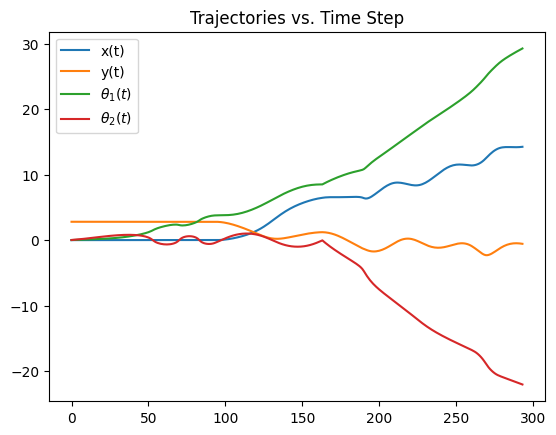

In [253]:
plt.figure()
plt.plot(np.concatenate((traj0[0:4].T, traj1[0:4].T)))
plt.legend(["x(t)", "y(t)", r'$\theta_1(t)$', r'$\theta_2(t)$'])
plt.title("Trajectories vs. Time Step")
plt.show()

# Result

In [256]:
print(traj0.shape)
print(traj1.shape)
arr = np.hstack((traj0, traj1))
print(arr.shape)
animate(arr, L, W)

# move impact eq higher
# alpha within integrate function
# see if eleq1 can be symbolically solved
# find angle that works

Output hidden; open in https://colab.research.google.com to view.